## 1. 필요 정보 임포트 및 시드 고정

In [22]:
!git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git

Cloning into 'DeepLabV3Plus-Pytorch'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 541 (delta 0), reused 1 (delta 0), pack-reused 537
Receiving objects: 100% (541/541), 8.20 MiB | 5.23 MiB/s, done.
Resolving deltas: 100% (290/290), done.


In [1]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34058272768
free     : 34058207232
used     : 65536


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from efficientunet import *
from torch.optim import lr_scheduler, Adam, SGD

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

def seed_all(seed = 42):
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    #random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
seed_all()

## 2. 데이터 전처리 및 데이터셋 선언

loading annotations into memory...
Done (t=3.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
655 41 53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])


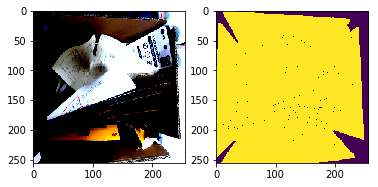

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


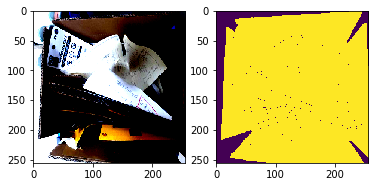

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


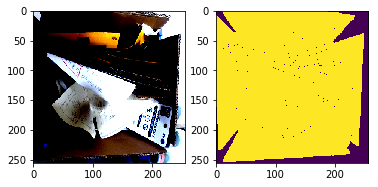

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


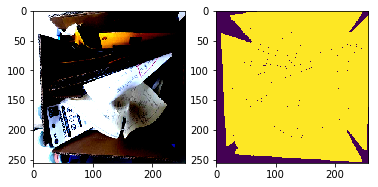

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


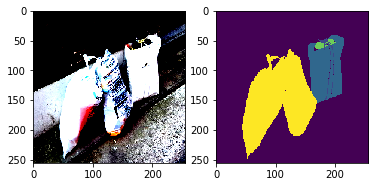

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


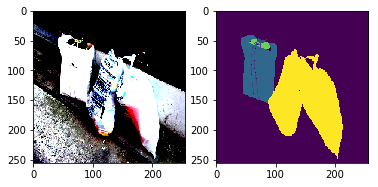

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


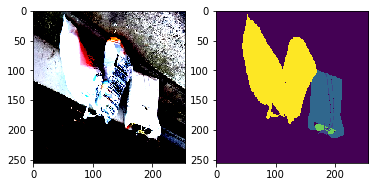

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


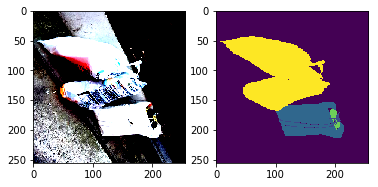

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


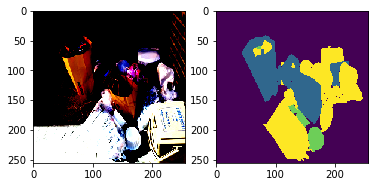

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


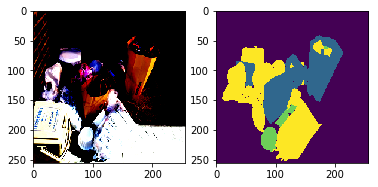

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


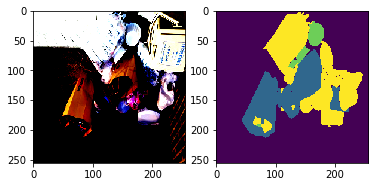

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


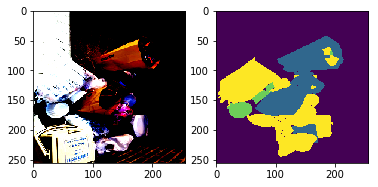

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


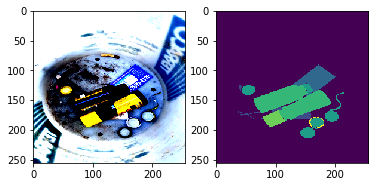

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


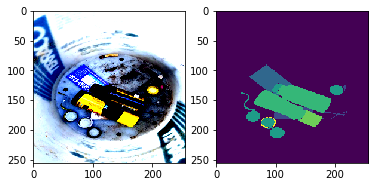

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


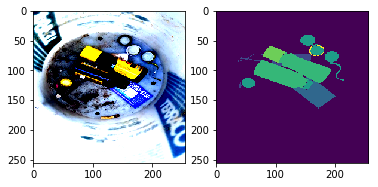

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([256, 256])


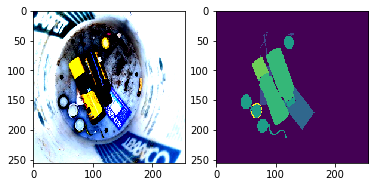

In [2]:
category_names = ["Backgroud","UNKNOWN","General trash","Paper","Paper pack","Metal","Glass","Plastic","Styrofoam","Plastic bag","Battery","Clothing"]
class_nums = len(category_names)

#CLAHE
def clahe_cvt(own_img) :
    lab = cv2.cvtColor(own_img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    cla_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return cla_img

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        '''
        self.aug = A.Compose([A.HorizontalFlip(0.5),
                              A.VerticalFlip(0.5),
                              A.RandomRotate90(0.5),
                              ToTensorV2()])
        '''
        self.hor = A.Compose([A.HorizontalFlip(1), ToTensorV2()])
        self.ver = A.Compose([A.VerticalFlip(1), ToTensorV2()])
        self.ran = A.Compose([A.RandomRotate90(1), ToTensorV2()])
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        #CLAHE Convert
        #images = clahe_cvt(images)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        #images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                
                if self.mode == 'train' :
                    hor_img = self.hor(image = images, mask = masks)
                    ver_img = self.ver(image = images, mask = masks)
                    ran_img = self.ran(image = images, mask = masks)
                    #aug_img = self.aug(image = images, mask = masks)
                    transformed = A.Compose([ToTensorV2()])(image = images, mask = masks)
                    images = transformed["image"]
                    masks = transformed["mask"]
                
                    images = (images, hor_img["image"], ver_img["image"], ran_img["image"])
                    masks = (masks, hor_img["mask"], ver_img["mask"], ran_img["mask"])
                
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
    
# train.json / validation.json / test.json 디렉토리 설정
dataset_path = 'input/data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch): return tuple(zip(*batch))

train_transform = A.Compose([
                            A.Resize(256, 256),
                            #A.HorizontalFlip(0.25),
                            #A.VerticalFlip(0.25),
                            #A.RandomRotate90(0.25),
                            #A.GaussianBlur(1),
                            A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                            ),
                            #ToTensorV2(),
                            ])

val_transform = A.Compose([
                           #A.CLAHE(),
                          A.Resize(256, 256),
                          A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                          ),
                          ToTensorV2(),
                          ])

test_transform = A.Compose([
                           #A.CLAHE(),
                           A.Resize(256, 256),
                           A.Normalize(
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0
                           ),
                           ToTensorV2(),
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

print(len(train_loader), len(val_loader), len(test_loader))

isFirst = True
for x, y, _ in train_loader :
    
    x_tmp = list()
    y_tmp = list()
    for i in range(len(x)) :
        for j in range(len(x[i])) :
            x_tmp.append(x[i][j])
            y_tmp.append(y[i][j])
    
    x = torch.stack(x_tmp)
    y = torch.stack(y_tmp)
    
    #x = torch.stack(x)
    #y = torch.stack(y).long()
    print(x.shape, y.shape)
    
    for i in range(len(x)) :
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
        print(x[i].shape, y[i].shape)
        ax1.imshow(x[i].numpy().transpose(1, 2, 0))
        ax2.imshow(y[i])
        plt.show()
    
    break

## 3. 모델 구축

In [5]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist

In [6]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

model_b7 = get_efficientunet_b7(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
#optimizer_7 = Adam(model_b7.parameters(), lr = 0.001)
#optimizer_7 = SGD(model_b7.parameters(), lr = 0.0001, momentum=0.9)
optimizer_7 = Adam(params = model_b7.parameters(), lr = 0.0001, weight_decay=1e-6)
criterion_7 = nn.CrossEntropyLoss()
scheduler_7 = lr_scheduler.StepLR(optimizer_7, step_size = 7, gamma = 0.1)
'''
#제대로 된 전처리 찾으면 다 학습시켜서 앙상블할 예정.

model_b6 = get_efficientunet_b6(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
optimizer_6 = Adam(model_b6.parameters(), lr = 0.001)
criterion_6 = nn.CrossEntropyLoss()
scheduler_6 = lr_scheduler.StepLR(optimizer_6, step_size = 7, gamma = 0.1)

model_b5 = get_efficientunet_b5(out_channels = class_nums, concat_input = True, pretrained = True).to(device)
optimizer_5 = Adam(model_b5.parameters(), lr = 0.001)
criterion_5 = nn.CrossEntropyLoss()
scheduler_5 = lr_scheduler.StepLR(optimizer_5, step_size = 7, gamma = 0.1)
'''

'\n#제대로 된 전처리 찾으면 다 학습시켜서 앙상블할 예정.\n\nmodel_b6 = get_efficientunet_b6(out_channels = class_nums, concat_input = True, pretrained = True).to(device)\noptimizer_6 = Adam(model_b6.parameters(), lr = 0.001)\ncriterion_6 = nn.CrossEntropyLoss()\nscheduler_6 = lr_scheduler.StepLR(optimizer_6, step_size = 7, gamma = 0.1)\n\nmodel_b5 = get_efficientunet_b5(out_channels = class_nums, concat_input = True, pretrained = True).to(device)\noptimizer_5 = Adam(model_b5.parameters(), lr = 0.001)\ncriterion_5 = nn.CrossEntropyLoss()\nscheduler_5 = lr_scheduler.StepLR(optimizer_5, step_size = 7, gamma = 0.1)\n'

In [7]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 34058272768
free     : 32272613376
used     : 1785659392


In [ ]:
n_epoch = 10 #parameter
best_val_loss = 999999
best_train_loss = 999999

for epoch in range(n_epoch) :
    #학습
    isFirst = True
    model_b7.train()
    train_loss = 0
    hist = np.zeros((class_nums, class_nums))
    for x, y, _ in tqdm(train_loader) :
        '''
        x_tmp = list()
        y_tmp = list()
        for i in range(len(x)) :
            for j in range(len(x[i])) :
                x_tmp.append(x[i][j])
                y_tmp.append(y[i][j])
        x = torch.stack(x_tmp)
        y = torch.stack(y_tmp).long()
        '''
        #print(x.shape, y.shape)
        x = torch.stack(x)       # (batch, channel, height, width)
        y = torch.stack(y).long()  # (batch, channel, height, width)
        x, y = x.to(device), y.to(device)
        
        predict = model_b7(x)
        
        if isFirst :
            with torch.no_grad() :
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                isFirst = False
                x_np = x[0].to('cpu').numpy()
                x_np = np.transpose(x_np, (1, 2, 0))
                ax1.imshow(x_np)
                ax2.imshow(y[0].to('cpu'))
                
                oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                ax3.imshow(oms)#, cmap='jet')
                plt.show()
            
        
        loss = criterion_7(predict, y)
        train_loss += loss.item()
        optimizer_7.zero_grad()
        loss.backward()
        optimizer_7.step()
        
        predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
        #print(predict.shape)
        hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)
        
    _, _, train_miou, _ = label_accuracy_score(hist)
    
    train_loss = train_loss / len(train_loader)
    #테스트
    isFirst = True
    model_b7.eval()
    valid_loss = 0
    with torch.no_grad() :
        hist = np.zeros((class_nums, class_nums))
        for x, y, _ in tqdm(val_loader) :
            x = torch.stack(x)
            y = torch.stack(y).long()
            x, y = x.to(device), y.to(device)

            predict = model_b7(x)

            if isFirst :
                with torch.no_grad() :
                    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                    isFirst = False
                    x_np = x[0].to('cpu').numpy()
                    x_np = np.transpose(x_np, (1, 2, 0))
                    ax1.imshow(x_np)
                    ax2.imshow(y[0].to('cpu'))

                    oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                    ax3.imshow(oms)#, cmap='jet')
                    plt.show()
            
            loss = criterion_7(predict, y)
            valid_loss += loss.item()
            
            predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
            #print(predict.shape)
            hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)

    _, _, mIoU, _ = label_accuracy_score(hist)
    valid_loss = valid_loss / len(train_loader)
    
    print('{0} / {1} : train_loss = {2:.4f}, train_acc = {3:.4f}, valid_loss = {4:.4f}, valid_acc = {5:.4f}'.format(epoch+1, n_epoch, train_loss, train_miou, valid_loss, mIoU))
    if train_loss < best_train_loss and valid_loss < best_val_loss :
        best_train_loss = train_loss
        best_val_loss = valid_loss
        model_name = 'b7_original_aug'
        print('save the model :', model_name)
        torch.save(model_b7.state_dict(), model_name + '.pt')
        
    if train_loss < 0.1 : 
        print('early stop')
        break
    scheduler_7.step()

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet101
from torchsummaryX import summary

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = deeplabv3_resnet101(pretrained=True)
model.classifier[-1] = nn.Conv2d(256, 12, kernel_size = 1, stride = 1)
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr = 0.0001, weight_decay=1e-6)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


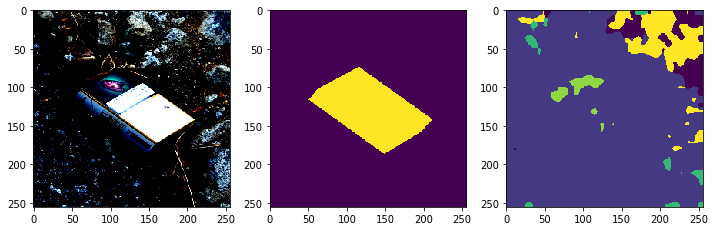

100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


1 / 20 : train_loss = 0.8169, train_acc = 0.1651, valid_loss = 0.0306, valid_acc = 0.2044
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


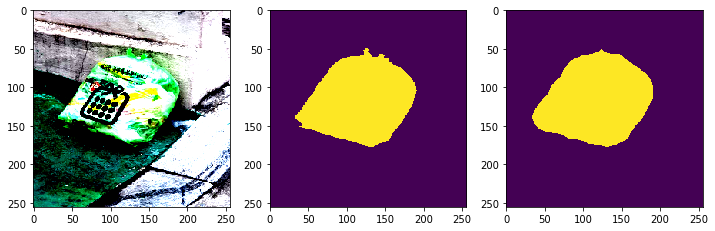

100%|██████████| 41/41 [00:15<00:00,  2.61it/s]


2 / 20 : train_loss = 0.4996, train_acc = 0.2170, valid_loss = 0.0281, valid_acc = 0.2562
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


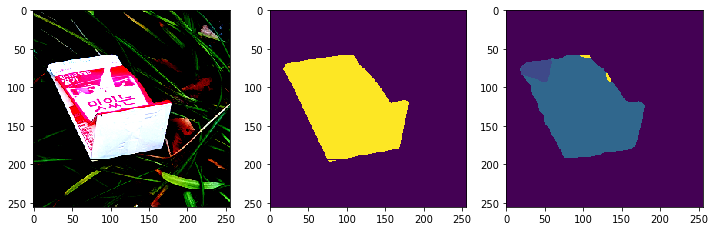

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


3 / 20 : train_loss = 0.4306, train_acc = 0.2509, valid_loss = 0.0251, valid_acc = 0.2821
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


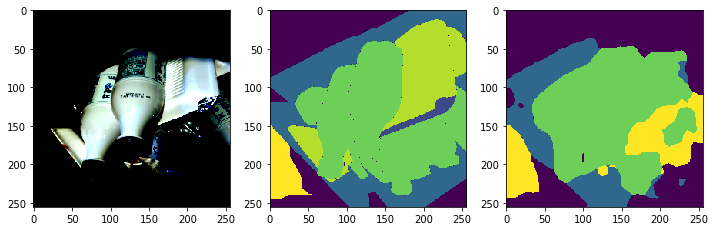

100%|██████████| 41/41 [00:15<00:00,  2.62it/s]


4 / 20 : train_loss = 0.3723, train_acc = 0.2900, valid_loss = 0.0247, valid_acc = 0.3170
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


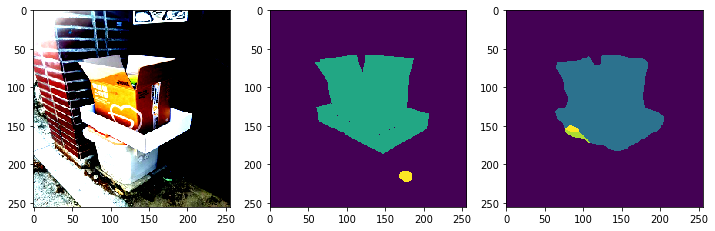

100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


5 / 20 : train_loss = 0.3432, train_acc = 0.3343, valid_loss = 0.0246, valid_acc = 0.3482
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


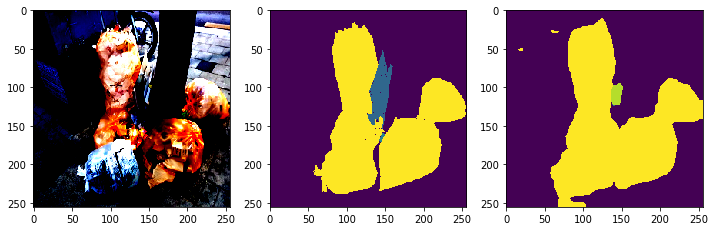

100%|██████████| 41/41 [00:16<00:00,  2.50it/s]


6 / 20 : train_loss = 0.2995, train_acc = 0.3890, valid_loss = 0.0223, valid_acc = 0.3743
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


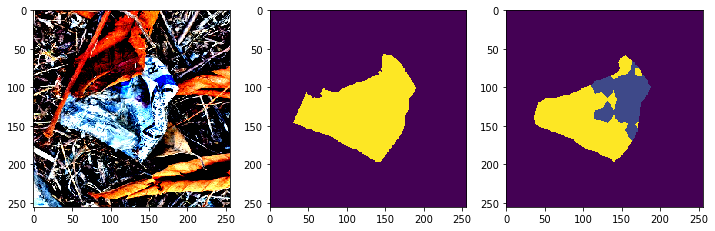

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


7 / 20 : train_loss = 0.2705, train_acc = 0.4410, valid_loss = 0.0219, valid_acc = 0.3931
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


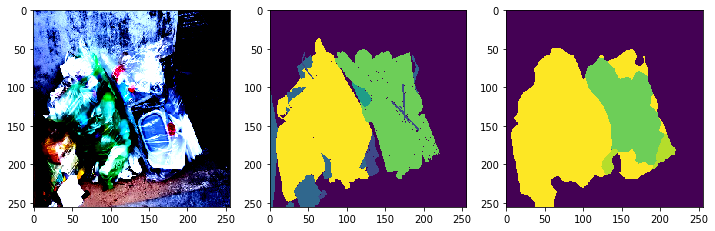

100%|██████████| 41/41 [00:15<00:00,  2.64it/s]


8 / 20 : train_loss = 0.2138, train_acc = 0.5232, valid_loss = 0.0200, valid_acc = 0.4251
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


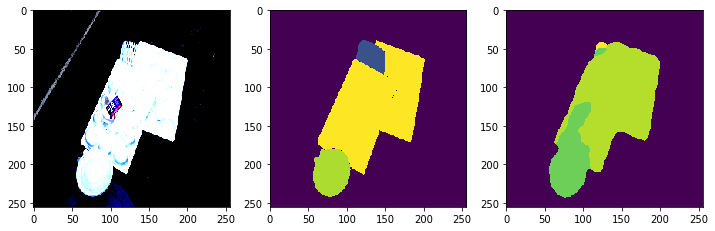

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


9 / 20 : train_loss = 0.1896, train_acc = 0.5579, valid_loss = 0.0199, valid_acc = 0.4308
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


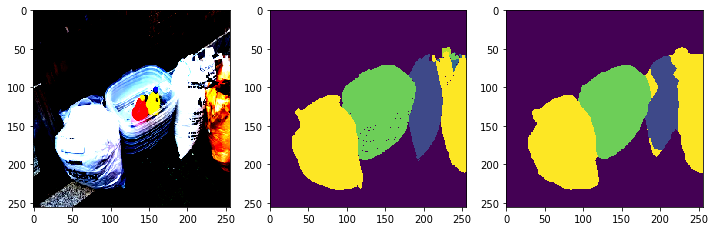

  0%|          | 0/655 [00:00<?, ?it/s]

10 / 20 : train_loss = 0.1761, train_acc = 0.5802, valid_loss = 0.0203, valid_acc = 0.4279


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


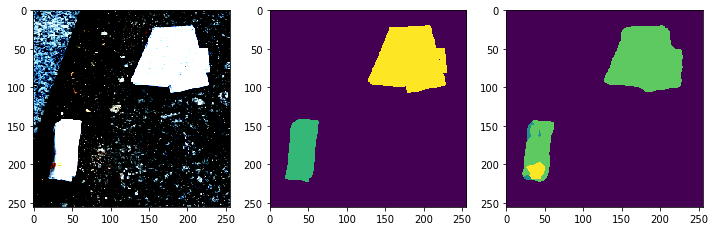

100%|██████████| 41/41 [00:16<00:00,  2.50it/s]


11 / 20 : train_loss = 0.1647, train_acc = 0.6006, valid_loss = 0.0200, valid_acc = 0.4383
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


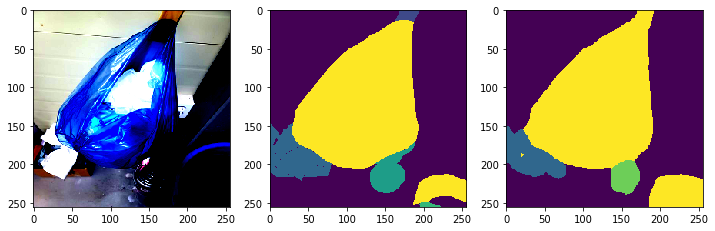

  0%|          | 0/655 [00:00<?, ?it/s]

12 / 20 : train_loss = 0.1574, train_acc = 0.6141, valid_loss = 0.0201, valid_acc = 0.4371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


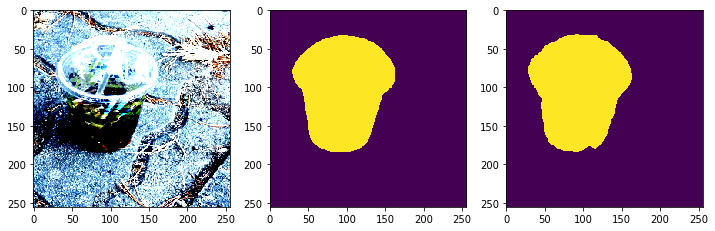

  0%|          | 0/655 [00:00<?, ?it/s]

13 / 20 : train_loss = 0.1487, train_acc = 0.6282, valid_loss = 0.0211, valid_acc = 0.4234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


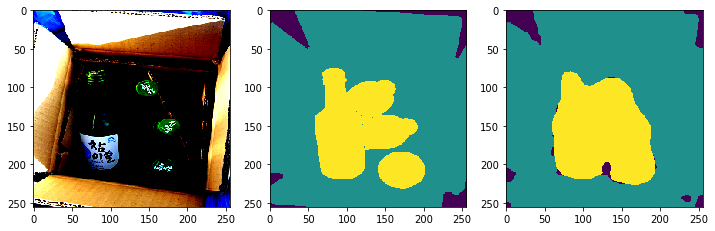

100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


14 / 20 : train_loss = 0.1395, train_acc = 0.6500, valid_loss = 0.0204, valid_acc = 0.4440
save the model : resnet101_deeplabv3_aug.pt


  0%|          | 0/655 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


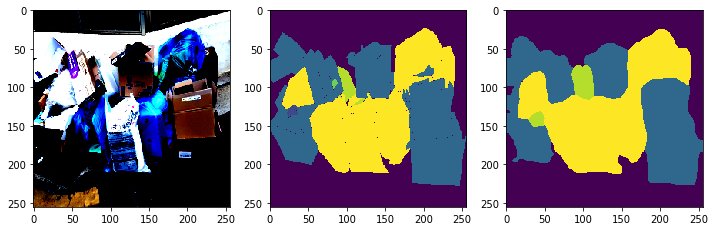

  0%|          | 0/655 [00:00<?, ?it/s]

15 / 20 : train_loss = 0.1325, train_acc = 0.6597, valid_loss = 0.0205, valid_acc = 0.4373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


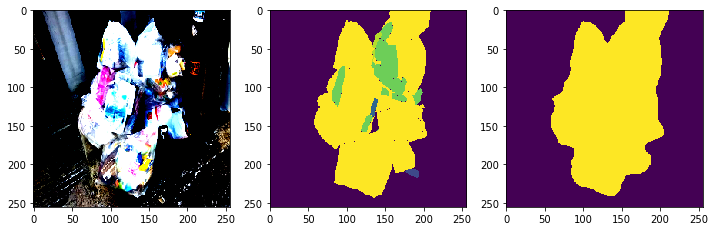

  0%|          | 0/655 [00:00<?, ?it/s]

16 / 20 : train_loss = 0.1300, train_acc = 0.6692, valid_loss = 0.0209, valid_acc = 0.4315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


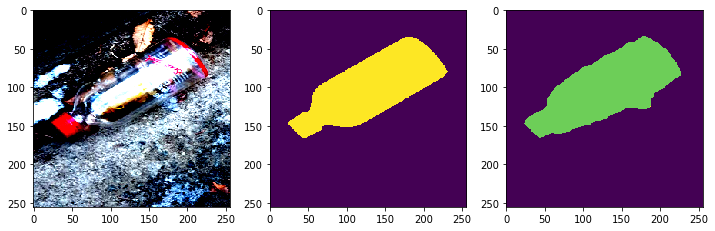

  0%|          | 0/655 [00:00<?, ?it/s]

17 / 20 : train_loss = 0.1296, train_acc = 0.6658, valid_loss = 0.0207, valid_acc = 0.4344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


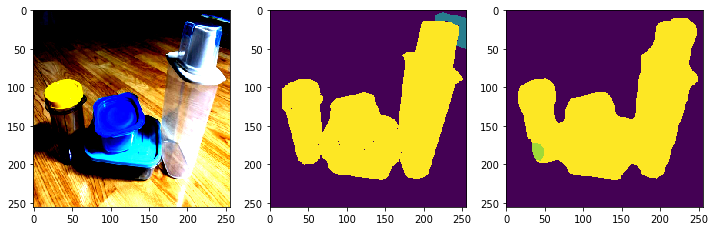

  0%|          | 0/655 [00:00<?, ?it/s]

18 / 20 : train_loss = 0.1290, train_acc = 0.6701, valid_loss = 0.0209, valid_acc = 0.4266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


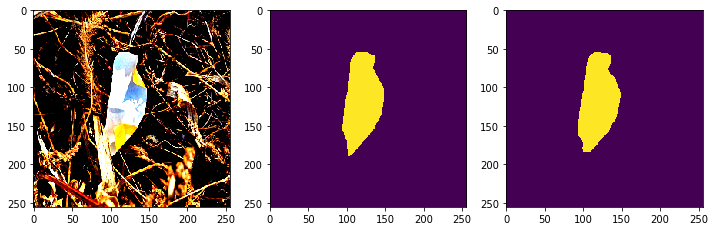

  0%|          | 0/655 [00:00<?, ?it/s]

19 / 20 : train_loss = 0.1281, train_acc = 0.6696, valid_loss = 0.0208, valid_acc = 0.4366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


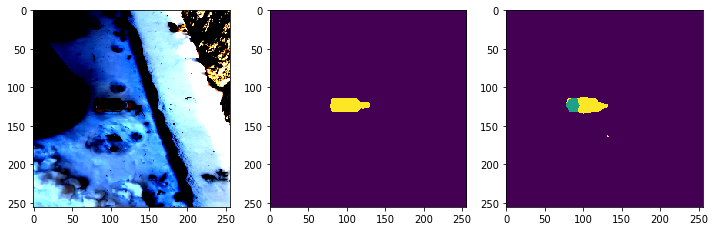

100%|██████████| 41/41 [00:16<00:00,  2.54it/s]

20 / 20 : train_loss = 0.1269, train_acc = 0.6717, valid_loss = 0.0210, valid_acc = 0.4343


In [9]:
n_epoch = 20 #parameter
best_val_acc = -1
best_train_acc = -1

for epoch in range(n_epoch) :
    #학습
    isFirst = True
    model.train()
    train_loss = 0
    hist = np.zeros((class_nums, class_nums))
    for x, y, _ in tqdm(train_loader) :
        #x = torch.stack(x)       # (batch, channel, height, width)
        #y = torch.stack(y).long()  # (batch, channel, height, width)
        
        x_tmp = list()
        y_tmp = list()
        for i in range(len(x)) :
            for j in range(len(x[i])) :
                x_tmp.append(x[i][j])
                y_tmp.append(y[i][j])
        x = torch.stack(x_tmp)
        y = torch.stack(y_tmp).long()
        
        x, y = x.to(device), y.to(device)
        '''
        if x.shape[0] == 1 :
            x_clone = x.clone()
            x = (x, x_clone)
            x = torch.stack(x)
            y_clone = y.clone()
            y = (y, y_clone)
            y = torch.stack(y)
            x = x.reshape(2, 3, 256, 256)
            y = y.reshape(2, 256, 256)
        '''
        predict = model(x)["out"]
        
        if isFirst :
            with torch.no_grad() :
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
                isFirst = False
                x_np = x[0].to('cpu').numpy()
                x_np = np.transpose(x_np, (1, 2, 0))
                ax1.imshow(x_np)
                ax2.imshow(y[0].to('cpu'))
                
                oms = torch.argmax(predict[0].squeeze(), dim=0).detach().cpu().numpy()                
                ax3.imshow(oms)#, cmap='jet')
                plt.show()
            
        
        loss = criterion(predict, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
        #print(predict.shape)
        hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)
        
    _, _, train_miou, _ = label_accuracy_score(hist)
    train_loss = train_loss / len(train_loader)
    #테스트
    model.eval()
    valid_loss = 0
    with torch.no_grad() :
        hist = np.zeros((class_nums, class_nums))
        for x, y, _ in tqdm(val_loader) :
            x = torch.stack(x)
            y = torch.stack(y).long()
            x, y = x.to(device), y.to(device)
            if x.shape[0] == 1 :
                x_clone = x.clone()
                x = (x, x_clone)
                x = torch.stack(x)
                y_clone = y.clone()
                y = (y, y_clone)
                y = torch.stack(y)
                x = x.reshape(2, 3, 256, 256)
                y = y.reshape(2, 256, 256)

            predict = model(x)["out"]
            
            loss = criterion(predict, y)
            valid_loss += loss.item()
            
            predict = torch.argmax(predict, dim = 1).detach().cpu().numpy()
            #print(predict.shape)
            hist = add_hist(hist, y.detach().cpu().numpy(), predict, n_class = class_nums)

    _, _, mIoU, _ = label_accuracy_score(hist)
    valid_loss = valid_loss / len(train_loader)
    
    print('{0} / {1} : train_loss = {2:.4f}, train_acc = {3:.4f}, valid_loss = {4:.4f}, valid_acc = {5:.4f}'.format(epoch+1, n_epoch, train_loss, train_miou, valid_loss, mIoU))
    if train_miou > best_train_acc and mIoU > best_val_acc :
        best_train_acc = train_miou
        best_val_acc = mIoU
        model_name = 'resnet101_deeplabv3_aug.pt'
        print('save the model :', model_name)
        torch.save(model.state_dict(), model_name)
        
    if train_loss < 0.05 : 
        #과적합 방지
        print('early stop')
        break
    scheduler.step()

In [13]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in tqdm(enumerate(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))['out']
            
            if outs.shape[0] == 1 : oms = torch.argmax(outs.squeeze(), dim = 0).detach().cpu().numpy()
            else : oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            oms = oms.reshape(-1, 256, 256)
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                #transformed = transform(image=img, mask=mask)
                #mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array



model.load_state_dict(torch.load('resnet101_deeplabv3_aug.pt'))
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)
# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)
# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)
# submission.csv로 저장
submission.to_csv("./submission/solo_aug.csv", index=False)

Start prediction.


53it [00:25,  2.11it/s]


End prediction.


In [11]:
model_name = 'resnet101_deeplabv3_aug_full.pt'
print('save the model :', model_name)
torch.save(model.state_dict(), model_name)

save the model : resnet101_deeplabv3_aug_full.pt
